# Demo of LSTMs for Time Series in PyTorch

From blogpost by Jessica Yung<br>
URL: https://www.jessicayung.com/lstms-for-time-series-in-pytorch/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from generate_data import *
import matplotlib.pyplot as plt

%matplotlib inline

## Parameters

In [3]:
# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params
input_size = 20
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 32
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 500
dtype = torch.float

## Prepare time-series data 
Source: https://github.com/jessicayung/blog-code-snippets

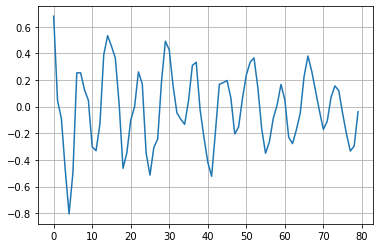

In [19]:
from generate_data import ARData

data = ARData(num_datapoints, num_prev=input_size, test_size=test_size, noise_var=noise_var, coeffs=fixed_ar_coefficients[input_size])
plt.plot(data.y_train)
plt.grid()
plt.show()

In [21]:
[tuple(d.shape) for d in [data.X_train, data.y_train, data.X_test, data.y_test]]

[(80, 20), (80,), (20, 20), (20,)]

In [18]:
# make training and test sets in torch

#Dimensions of X data:
# 0. sequence position (i.e. timestep t)
# 1. training sample
# 2. input variable (only 1 in this case)
# Dimensions of y data:
# 0. training sample
X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])

[tuple(d.shape) for d in [X_train, y_train, X_test, y_test]]

[(20, 80, 1), (80,), (20, 20, 1), (20,)]

In [12]:
data.X_train.shape

(80, 20)

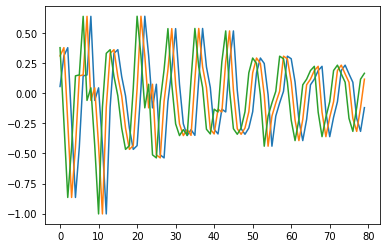

In [17]:
plt.plot(data.X_train[:, 0])
plt.plot(data.X_train[:, 1])
plt.plot(data.X_train[:, 2])

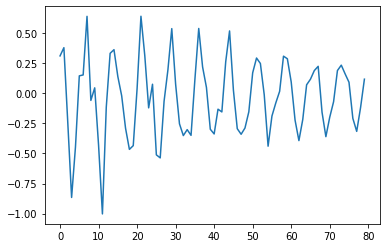

## Build model

In [18]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=False)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

//anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Train model

In [19]:
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  0 MSE:  0.9976394772529602
Epoch  100 MSE:  0.8837292194366455
Epoch  200 MSE:  0.7504588961601257
Epoch  300 MSE:  0.6962876915931702
Epoch  400 MSE:  0.678634762763977


## Plot preds and performance

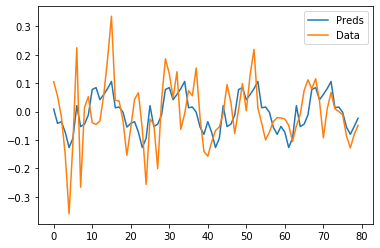

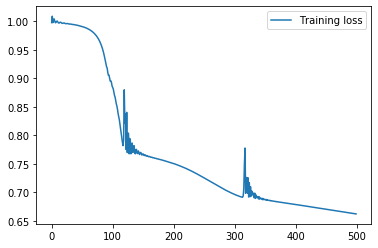

In [20]:
plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()